## Create ARIMA models to forecast depth to ground water


###  How do ARIMA models work?
ARIMA models are a combine and autoregressive component, with a moving average model, with some degree of differencing. The moving average component can be expressed in the following way.

$$ y_t = c + \phi_1y_{t-1} + \phi_2y_{t-2} + ... + \phi_py_{t-p} + \varepsilon_t $$

This way, the next value in the time series can be expressed as a linear combination of the previous values. The number of previous values to consider is expressed by the parameter *p*.

The moving average component can be expressed in the following way.

$$ y_t = c + \theta_1\varepsilon_{t-1} + \theta_2\varepsilon_{t-2} + ... + \theta_p\varepsilon_{t-q} + \varepsilon_t $$

The moving average uses past forecast errors $\varepsilon_{t-q}$ to to calculate the moving average. The orderof the moving average model is describe by parameter *q*.

All of this is combined with an order of differencing where the order is described by parameter *d*.

To fully explain how the model works, we must introduce backshift notation. We introduce an operator *B*, which performs an operation on value $y_t$ in the following way.
$$By_t = y_{t-1}$$
$$B^2y_t = y_{t-2}$$
$$B^ny_t = y_{t-n}$$

Combining all three components, the model can be expresed using the following equation.
$$ (1 - \phi_1B_p - ... \phi_pB^p) (1 - B)^d y_t = c + (1 + \theta_1B + ... + \theta_qB^q)\varepsilon_t$$

For whatever parameter selection of p, d or q, this equation can be rearranged to find value $y_t$. This way the forecasted value can be calculated based on previous values of the time series. The weights $\phi_p$ and $\theta_q$ are fitted to the data using a Maximum likelihood estimator, such as Least squares estimation.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Load data from preprocessing

In [4]:
df = pd.read_csv("../Processed_data/processed_data.csv", index_col="Unnamed: 0")
df.head()

,Date,Rainfall,Depth_to_groundwater,Temperature,Drainage_Volume,Hydrometry,Depth_to_groundwater_diff_1,Depth_to_groundwater_diff_2,Month,Day,...,Hydrometry_res,Depth_to_groundwater_trend,Depth_to_groundwater_seasonal,Depth_to_groundwater_res,Depth_to_groundwater_diff_1_trend,Depth_to_groundwater_diff_1_seasonal,Depth_to_groundwater_diff_1_res,Depth_to_groundwater_diff_2_trend,Depth_to_groundwater_diff_2_seasonal,Depth_to_groundwater_diff_2_res
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4,0.00,0.00,1,1,...,0.053435,-29.587662,-0.673243,-0.879095,0.000478,-0.003122,0.002644,-0.000085,0.020845,-0.020760
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5,0.03,0.03,1,2,...,0.169867,-29.582438,-0.660836,-0.866727,0.000492,0.012756,0.016752,-0.000085,0.015900,0.014185
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4,0.04,0.01,1,3,...,0.105889,-29.577213,-0.619997,-0.872789,0.000506,0.024219,0.015275,-0.000085,0.011693,-0.001608
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4,0.02,-0.02,1,4,...,0.088990,-29.571989,-0.591599,-0.886412,0.000520,0.028416,-0.008936,-0.000084,0.004222,-0.024138
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3,0.04,0.02,1,5,...,-0.027932,-29.566765,-0.573141,-0.870094,0.000534,0.018473,0.020994,-0.000084,-0.009919,0.030004


### Transform depth to groundwater diff 2 back to depth to groundwater
- Integrate + add some constant
- Can represent this as a cumulatvive sum
- To go from Diff2 to diff1, do 1 cumulative sum + add a constant (integrate once)
    - Constant is the 1st value of diff1 (0 in our case)
- To go from Diff2 to original, do 2 cumulative sums + add a constant after each cumsum (integrate twice)
    - 2nd Constant is the 1st value of the original series

<br>

$$h = \text{depth to groundwater}$$
$$\frac{dh}{dt} = \int{\frac{d^2h}{dt^2}} dt $$
$$\frac{dh}{dt} =  \text{cumsum}\left( \frac{d^2h}{dt^2} \right)  + C_1 $$
$$h =  \int\int{\frac{d^2h}{dt^2}}dt^2$$
$$h = \text{cumsum}\left(\text{cumsum}\left( \frac{d^2h}{dt^2} \right)  + C_1\right) + C_2 $$


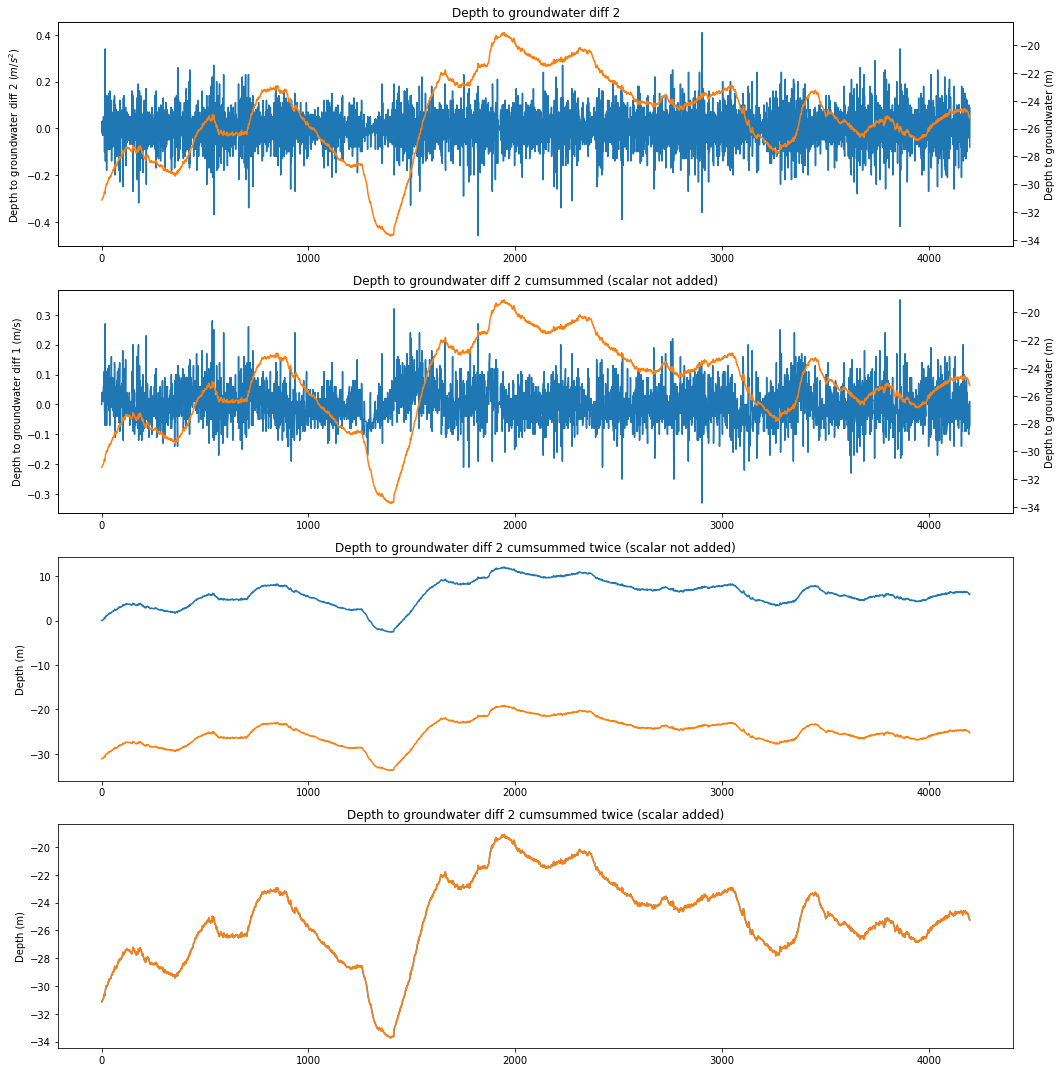

In [5]:
fig, ax = plt.subplots(4,1, figsize=(15,15))

ax[0].set_title("Depth to groundwater diff 2")
ax[0].plot(df.Depth_to_groundwater_diff_2)
ax[0].set_ylabel("Depth to groundwater diff 2 $(m/s^2)$")
ax0_2 = ax[0].twinx()
ax0_2.plot(df.Depth_to_groundwater, color="C1")
ax0_2.set_ylabel("Depth to groundwater (m)")


ax[1].set_title("Depth to groundwater diff 2 cumsummed (scalar not added)")
ax[1].plot(df.Depth_to_groundwater_diff_2.cumsum())
ax[1].set_ylabel("Depth to groundwater diff 1 (m/s)")
ax1_2 = ax[1].twinx()
ax1_2.plot(df.Depth_to_groundwater, color="C1")
ax1_2.set_ylabel("Depth to groundwater (m)")

ax[2].set_title("Depth to groundwater diff 2 cumsummed twice (scalar not added)")
ax[2].plot(df.Depth_to_groundwater_diff_2.cumsum().cumsum())
ax[2].plot(df.Depth_to_groundwater)
ax[2].set_ylabel("Depth (m)")

ax[3].set_title("Depth to groundwater diff 2 cumsummed twice (scalar added)")
ax[3].plot(df.Depth_to_groundwater_diff_2.cumsum().cumsum() + df.Depth_to_groundwater.iloc[0])
ax[3].plot(df.Depth_to_groundwater)
ax[3].set_ylabel("Depth (m)")


plt.tight_layout()

## Function for transforming 2nd derivative back to original

In [6]:
def inverse_transform_diff2s(df,output,start_ind):
    inv_trans = (output.cumsum() + df.Depth_to_groundwater_diff_1.iloc[start_ind-1]).cumsum() + df.Depth_to_groundwater.iloc[start_ind-1]
    return inv_trans

## Set up training set with cross validation

In [7]:
from sklearn.model_selection import TimeSeriesSplit
k = 10
max_test_size = 20
tscv = TimeSeriesSplit(n_splits = k)

## Forecast 10 values into the future

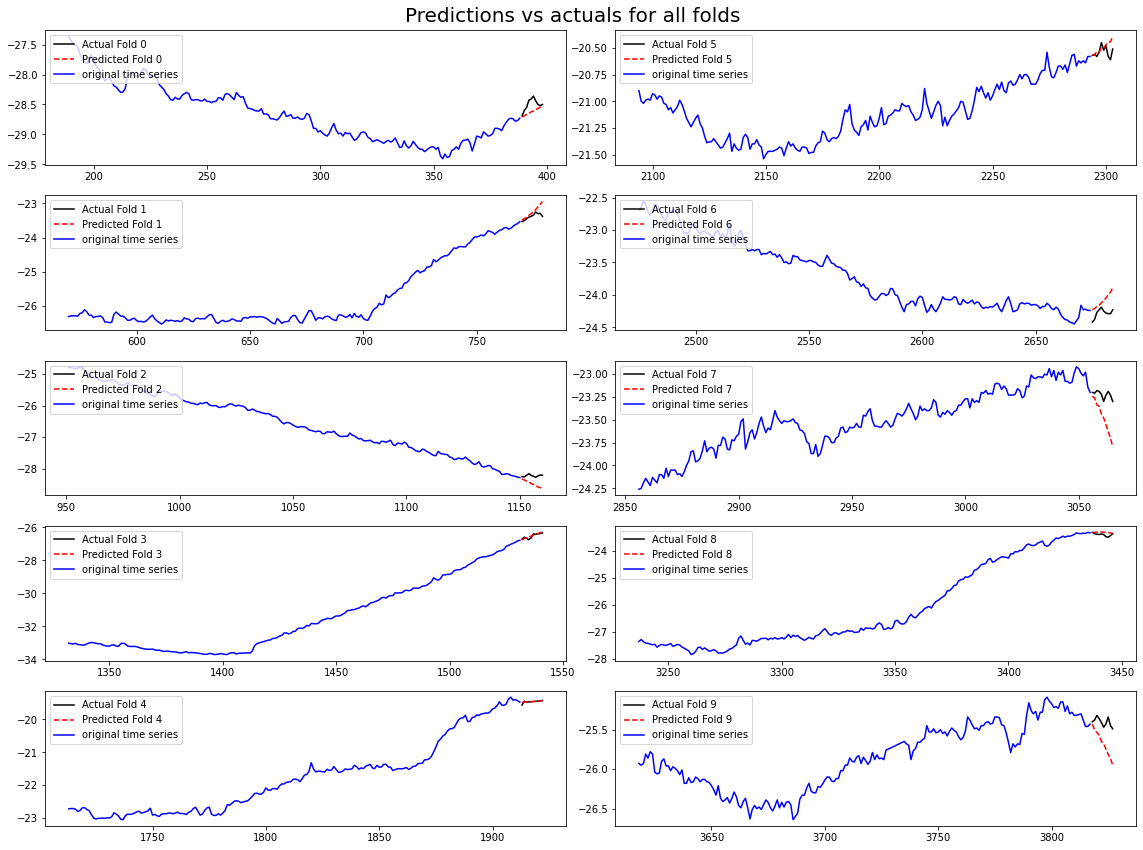

In [14]:
p = 6
d = 3
q = 10

MSE_scores = []
MAE_scores = []

fig, ax = plt.subplots(5,2, figsize = (16,12))

for fold, (train_index, test_index) in enumerate(tscv.split(df.Depth_to_groundwater_diff_2)):
    
    ax2 = int(fold/5)
    ax1 = int(fold%5)
#     print(ax1, ax2)
    
    #### for each fold prepare train and test set
    train, test = df.Depth_to_groundwater_diff_2[train_index], df.Depth_to_groundwater_diff_2[test_index]
    test = test[:10]
    
    ### create ARIMA model and fit to training data
    model = ARIMA(train, order = (p,d,q))
    model_fit = model.fit()
    
    #### generate models predictions
    result = model_fit.get_forecast(steps = len(test))
    preds = result.predicted_mean
    preds_transform = inverse_transform_diff2s(df,preds,test_index[0])
    
    ## get 95% confidence interval
    conf_int = result.conf_int()
    upper_conf_trans = inverse_transform_diff2s(df, conf_int.iloc[:, 0], test_index[0])
    lower_conf_trans = inverse_transform_diff2s(df, conf_int.iloc[:, 1], test_index[0])
    
    ### get mse and mae
    mse = mean_squared_error(test, preds)
    mae = mean_squared_error(test, preds)
    
    MSE_scores.append(mse)
    MAE_scores.append(mae)
    
    
    #### plot test and predicted
    ax[ax1, ax2].plot(test_index[:10], df.Depth_to_groundwater[test_index[:10]], color="black", label=f"Actual Fold {fold}")  # Test actuals
    ax[ax1, ax2].plot(test_index[:10], preds_transform, color="red", linestyle="dashed", label=f"Predicted Fold {fold}")  # Predictions

    # Confidence interval shading
    #ax[ax1, ax2].fill_between(test_index[:10], upper_conf_trans, lower_conf_trans, color='red', alpha=0.2)
    ax[ax1, ax2].plot(train_index[-200:], df.Depth_to_groundwater[train_index[-200:]], color='blue', label ="original time series", zorder = 1)
    ax[ax1, ax2].legend(loc="upper left")
    
fig.suptitle("Predictions vs actuals for all folds", fontsize=20)
plt.tight_layout()

## Look at residuals of model and density plot
- residuals show white noise and gaussian distribution

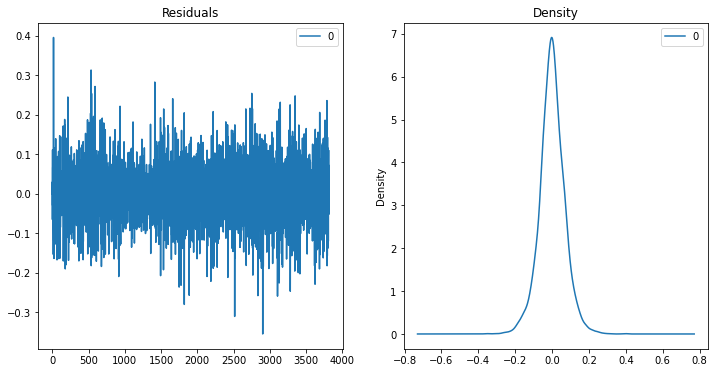

In [9]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(12,6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


## Find best parameters of p, q, d, using grid search

In [10]:
import itertools

p_vals = [2,3,4,6,8,10,12]
d_vals = [2,3,4]
q_vals = [2,3,4,6,8,10,12]

pdq_combos = list(itertools.product(p_vals, d_vals, q_vals))

MSE_dict = {}
MAE_dict = {}

for param in pdq_combos:
    
    MSE_list = []
    MAE_list = []
    
    for fold, (train_index, test_index) in enumerate(tscv.split(df.Depth_to_groundwater_diff_2)):

        #### for each fold prepare train and test set
        train, test = df.Depth_to_groundwater_diff_2[train_index], df.Depth_to_groundwater_diff_2[test_index]
        test = test[:10]

        ### create ARIMA model and fit to training data
        model = ARIMA(train, order = param)
        model_fit = model.fit()

        #### generate models predictions
        result = model_fit.get_forecast(steps = len(test))
        preds = result.predicted_mean
        preds_transform = inverse_transform_diff2s(df,preds,test_index[0])

        ## get 95% confidence interval
        conf_int = result.conf_int()
        upper_conf_trans = inverse_transform_diff2s(df, conf_int.iloc[:, 0], test_index[0])
        lower_conf_trans = inverse_transform_diff2s(df, conf_int.iloc[:, 1], test_index[0])

        ### get mse and mae
        mse = mean_squared_error(test, preds)
        mae = mean_absolute_error(test, preds)
        
        MSE_list.append(mse)
        MAE_list.append(mae)

    MSE_dict[param] = np.mean(MSE_list)
    MAE_dict[param] = np.mean(MAE_list)
    
    print(f"{param} model evaluated")

(2, 2, 2) model evaluated
(2, 2, 3) model evaluated
(2, 2, 4) model evaluated
(2, 2, 6) model evaluated
(2, 2, 8) model evaluated
(2, 2, 10) model evaluated
(2, 2, 12) model evaluated
(2, 3, 2) model evaluated
(2, 3, 3) model evaluated
(2, 3, 4) model evaluated
(2, 3, 6) model evaluated
(2, 3, 8) model evaluated
(2, 3, 10) model evaluated
(2, 3, 12) model evaluated
(2, 4, 2) model evaluated
(2, 4, 3) model evaluated
(2, 4, 4) model evaluated
(2, 4, 6) model evaluated
(2, 4, 8) model evaluated
(2, 4, 10) model evaluated
(2, 4, 12) model evaluated
(3, 2, 2) model evaluated
(3, 2, 3) model evaluated
(3, 2, 4) model evaluated
(3, 2, 6) model evaluated
(3, 2, 8) model evaluated
(3, 2, 10) model evaluated
(3, 2, 12) model evaluated
(3, 3, 2) model evaluated
(3, 3, 3) model evaluated
(3, 3, 4) model evaluated
(3, 3, 6) model evaluated
(3, 3, 8) model evaluated
(3, 3, 10) model evaluated
(3, 3, 12) model evaluated
(3, 4, 2) model evaluated
(3, 4, 3) model evaluated
(3, 4, 4) model evaluated
(3

## Find the best model based on MSE and MAE

In [11]:
sorted(MSE_dict.items(), key = lambda x:x[1])

[((12, 3, 12), 0.006544764161596878),
 ((4, 2, 10), 0.006584730068911758),
 ((4, 2, 6), 0.006600945506482622),
 ((8, 2, 10), 0.00662426279169358),
 ((4, 2, 2), 0.00662604962945741),
 ((2, 2, 4), 0.006699578971522192),
 ((2, 4, 6), 0.006708661787588601),
 ((3, 2, 3), 0.006728181498767111),
 ((6, 2, 6), 0.006729994098882966),
 ((2, 2, 2), 0.006758526511522587),
 ((10, 3, 12), 0.006761501540477775),
 ((12, 2, 3), 0.0067617825080793),
 ((6, 2, 12), 0.006763333004544135),
 ((2, 2, 3), 0.006782953870624933),
 ((12, 2, 6), 0.006785834953106815),
 ((2, 2, 6), 0.006787003201837812),
 ((10, 2, 3), 0.006797790422689373),
 ((2, 4, 8), 0.006800058048988189),
 ((4, 2, 4), 0.006826628169556685),
 ((4, 2, 12), 0.006839493302147277),
 ((8, 2, 8), 0.0068558014767050495),
 ((8, 2, 12), 0.006892186814341737),
 ((2, 3, 8), 0.006895644772080001),
 ((4, 3, 3), 0.006906077168759022),
 ((12, 2, 4), 0.006925013737988135),
 ((2, 2, 8), 0.00693254152777117),
 ((4, 4, 10), 0.006935216423323741),
 ((6, 3, 8), 0.006